In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from matplotlib import animation
import dill
from scipy.interpolate import interpn
import sys
import os
sys.path.append(os.path.expanduser('~') + '/igm_emulator/igm_emulator/emulator')
from emulator_run import nn_emulator

64
***Data Loaded***
Train datasize: 768; Test datasize: 89; Validation datasize: 358


In [2]:
true_temp_idx = 11
true_gamma_idx = 4
true_fobs_idx = 7
n_inference = 5

# small bin 4 -> 3
zstr = 'z54'
skewers_per_data = 20 #17->20
n_covar = 500000
bin_label = '_set_bins_3'
in_path_molly = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final_135/{zstr}/' 
#change path from f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'

# get initial grid
in_name_h5py = f'correlation_temp_fluct_skewers_2000_R_30000_nf_9_dict{bin_label}.hdf5'
with h5py.File(in_path_molly + in_name_h5py, 'r') as f:
    params = dict(f['params'].attrs.items())
fobs = params['average_observed_flux']
R_value = params['R']
v_bins = params['v_bins']
t_0s = 10.**params['logT_0']
gammas = params['gamma']
n_temps = len(t_0s)
n_gammas = len(gammas)
n_f = len(fobs)

noise_idx = 0
like_name_0 = f'likelihood_dicts_R_30000_nf_9_T{true_temp_idx}_G{true_gamma_idx}_SNR0_F{true_fobs_idx}_ncovar_500000_P{skewers_per_data}{bin_label}.p'
like_dict_0 = dill.load(open(in_path_molly + like_name_0, 'rb'))
mean_flux = like_dict_0['mean_data']
mock_name = f'mocks_R_{int(R_value)}_nf_{n_f}_T{true_temp_idx}_G{true_gamma_idx}_SNR{noise_idx}_F{true_fobs_idx}_P{skewers_per_data}{bin_label}.p'
mocks = dill.load(open(in_path_molly + mock_name, 'rb'))

In [3]:
print(mocks.shape, n_f, n_temps, n_gammas)

(1000, 59) 9 15 9


In [4]:
in_path_linda = '/mnt/quasar2/zhenyujin/igm_emulator/emulator/best_params/'
#emu_name = f'{zstr}_best_param_training_768_bin59.p' #small bins
emu_name = 'z54_training_768_bin59_chi_one_covariance_l2_1.6e-05_activation_tanh_layers_[100, 100, 59]_best_param.p' #optuna tuned
best_params = dill.load(open(in_path_linda + emu_name, 'rb'))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
temps_plot = np.empty([(n_temps-1) * 4 + 1])
for idx, temp in enumerate(t_0s[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
        temps_plot[new_idx + new_add_idx] = temp + (np.diff(t_0s)[idx] * new_add_idx / 4.)
temps_plot[-1] = t_0s[-1]

gammas_plot = np.empty([(n_gammas-1) * 4 + 1])
for idx, gamma in enumerate(gammas[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
        gammas_plot[new_idx + new_add_idx] = gamma + (np.diff(gammas)[idx] * new_add_idx / 4.)
gammas_plot[-1] = gammas[-1]

fobs_plot = np.empty([(n_f-1) * 4 + 1])
for idx, fob in enumerate(fobs[:-1]):
    new_idx = idx * 4
    for new_add_idx in range(4):
           fobs_plot[new_idx + new_add_idx] = fob + (np.diff(fobs)[idx] * new_add_idx / 4.)
fobs_plot[-1] = fobs[-1]

In [6]:
print(len(temps_plot),len(gammas_plot),len(fobs_plot))

57 33 33


## problem here: can't read mean corr in one file as an array to interpolate

plotting


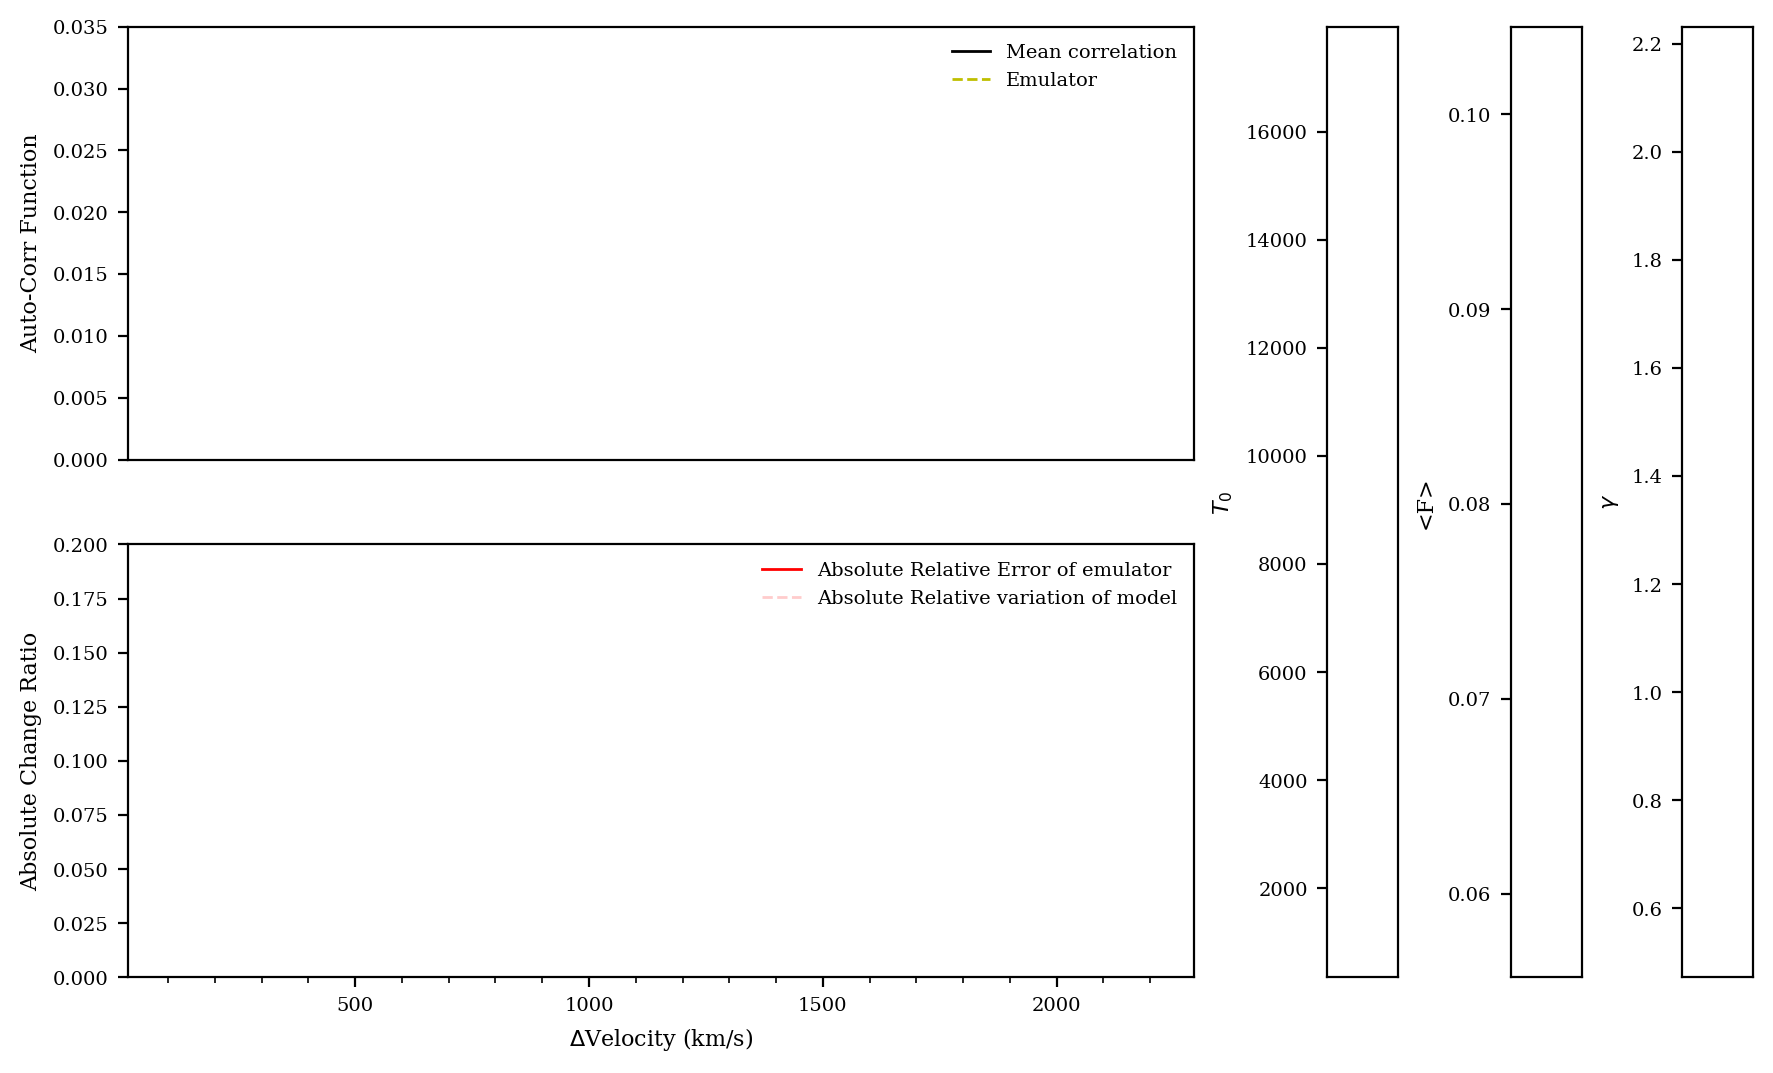

In [7]:
x_size = 3.5
dpi_value = 200

plt_params = {'legend.fontsize': 7,
              'legend.frameon': False,
              'axes.labelsize': 8,
              'axes.titlesize': 8,
              'figure.titlesize': 8,
              'xtick.labelsize': 7,
              'ytick.labelsize': 7,
              'lines.linewidth': 1,
              'lines.markersize': 2,
              'errorbar.capsize': 3,
              'font.family': 'serif',
              # 'text.usetex': True,
              'xtick.minor.visible': True,
              }
plt.rcParams.update(plt_params)

print('plotting')

make_autocorr_gif = plt.figure(
        figsize=(x_size*2.5, x_size*1.5), constrained_layout=True, dpi=dpi_value,
    )
    # simulation_fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
grid = make_autocorr_gif.add_gridspec(
        nrows=2, ncols=4, width_ratios=[15, 1, 1, 1], height_ratios=[1, 1],
    )

corr_ax = make_autocorr_gif.add_subplot(grid[0, 0])
corr_ax.set_ylabel(r'Auto-Corr Function')
corr_ax.set_xlim([v_bins[0], v_bins[-1]])
corr_ax.set_ylim([0., .035])

corr_ax.tick_params(
        axis='x',
        which='both',
        bottom=False,
        labelbottom=False
)

emu_ax = make_autocorr_gif.add_subplot(grid[1, 0], sharex=corr_ax)
emu_ax.set_ylabel(f'Absolute Change Ratio')
emu_ax.set_xlabel(r'$\Delta$Velocity (km/s)')
emu_ax.set_xlim([v_bins[0], v_bins[-1]])
emu_ax.set_ylim([0, .2])

t0s_ax = make_autocorr_gif.add_subplot(grid[:, 1])
t0s_ax.set_ylabel(r'$T_0$')
t0s_ax.set_ylim(t_0s[0], t_0s[-1])
t0s_ax.set_xlim(-0.5, 0.5)
t0s_ax.set_xticks([])
t0s_bar, = t0s_ax.bar([0], [0], width=1, color='C0', align='center', animated=True)

fobs_ax = make_autocorr_gif.add_subplot(grid[:, 2])
fobs_ax.set_ylabel(r'<F>')
fobs_ax.set_ylim(fobs[0], fobs[-1])
fobs_ax.set_xlim(-0.5, 0.5)
fobs_ax.set_xticks([])
fobs_bar, = fobs_ax.bar([0], [0], width=1, color='C1', align='center', animated=True)

gammas_ax = make_autocorr_gif.add_subplot(grid[:, 3])
gammas_ax.set_ylabel(r'$\gamma$')
gammas_ax.set_ylim(gammas[0], gammas[-1])
gammas_ax.set_xlim(-0.5, 0.5)
gammas_ax.set_xticks([])
gammas_bar, = gammas_ax.bar([0], [0], width=1, color='C2', align='center', animated=True)

# start defining the initial line with no  data
line_corr, = corr_ax.plot([], [], c='k',label='Mean correlation',)
line_emu, = corr_ax.plot([], [], c='y',label='Emulator',ls='--')
corr_ax.legend()
line_err, = emu_ax.plot([], [], c='r',label='Absolute Relative Error of emulator')
lin_var_max, = emu_ax.plot([], [], alpha =0.2, color='r',ls='--',label='Absolute Relative variation of model')
#lin_var_min, = emu_ax.plot([], [], alpha =0.2, color='r',ls='-.', label='Relative variation of model at min')
emu_ax.legend()

In [8]:
# get means in one array
means = np.empty([n_temps, n_gammas, n_f, len(v_bins)])
for t_idx in range(n_temps):
    for g_idx in range(n_gammas):
            for f_idx in range(n_f):
                like_name = f'likelihood_dicts_R_30000_nf_9_T{t_idx}_G{g_idx}_SNR0_F{f_idx}_ncovar_500000_P{skewers_per_data}{bin_label}.p'
                like_dict = dill.load(open(in_path_molly + like_name, 'rb'))
                means[t_idx, g_idx, f_idx, :] = like_dict['mean_data']
            
            
#def interpolate_mock:
def interpolate_mean_model(t, g, fob, models=means, model_t=t_0s, model_fobs=fobs, model_gs=gammas,
                           vbins=v_bins
                          ):
    loc = np.empty([len(vbins), 4])
    loc[:, 0] = t
    loc[:, 1] = g
    loc[:, 2] = fob
    loc[:, 3] = vbins
    mean_corr = interpn((model_t, model_gs, model_fobs,vbins), models, loc)
    return mean_corr

In [9]:
print(t_0s[0], t_0s[-1])

348.99999999999983 17948.999999999993


In [11]:
 def init():
        line_emu.set_data([], [])
        line_corr.set_data([], [])
        line_err.set_data([], [])
        lin_var_max.set_data([], [])
        #lin_var_min.set_data([], [])

        return line_emu, line_corr, line_err, lin_var_max, #lin_var_min, 
        t0s_bar, fobs_bar,gammas_bar, 

def animate(i):
        temps_preset = np.logspace(np.log10(t_0s[0]), np.log10(t_0s[-1]), 146)
        #fobs_preset = np.logspace(np.log10(fobs[0]), np.log10(fobs[-1]), 146)
        #gammas_preset = np.logspace(np.log10(gammas[0]), np.log10(gammas[-1]), 146)
        if i < 146:
            temps_set = temps_preset[i] 
            #fobs_set = fobs_preset[i]
            #gammas_set = gammas_preset[i]
        else:
            temps_set = temps_preset[int(146*2. - i - 1)]
            #fobs_set = fobs_preset[int(146*2. - i - 1)]
            #gammas_set = gammas_preset[int(146*2. - i - 1)]
        #temps_set = temps_plot[28]
        fobs_set = fobs_plot[16]
        gammas_set = gammas_plot[16]

        x_emu = v_bins
        y_emu = nn_emulator(best_params,[fobs_set,temps_set,gammas_set])
        line_emu.set_data(x_emu, y_emu)

        #x_mock = v_bins
        #y_mock = interpolate_mock(mfp_set, fobs_set)
        #line_mock.set_data(x_mock, y_mock)

        x_corr = v_bins
        y_corr = interpolate_mean_model(temps_set,gammas_set,fobs_set)
        line_corr.set_data(x_corr, y_corr)
        
        x_err = v_bins
        y_err = abs((y_corr-y_emu)/y_corr)
        line_err.set_data(x_err, y_err)
        
        temps_max = interpolate_mean_model(temps_plot[-1],gammas_set,fobs_set)
        temps_min = interpolate_mean_model(temps_plot[0],gammas_set,fobs_set)
        fobs_max = interpolate_mean_model(temps_set,gammas_set,fobs_plot[-1])
        fobs_min = interpolate_mean_model(temps_set,gammas_set,fobs_plot[0])
        gammas_max = interpolate_mean_model(temps_set,gammas_plot[-1],fobs_set)
        gammas_min = interpolate_mean_model(temps_set,gammas_plot[0],fobs_set)
        
        x_var = v_bins
        #y_var_max = abs((temps_max-temps_min)/y_corr)
        #y_var_min = (temps_max-y_corr)/y_corr
        y_var_max = (fobs_max-fobs_min)/y_corr
        #y_var_min = (fobs_max-y_corr)/y_corr
        #y_var_max = (y_corr-gammas_min)/y_corr
        #y_var_min = (gammas_max-y_corr)/y_corr
        lin_var_max.set_data(x_var,y_var_max)
        #lin_var_min.set_data(x_var,y_var_min)

        t0s_bar.set_height(temps_set)
        fobs_bar.set_height(fobs_set)
        gammas_bar.set_height(gammas_set)

        return line_emu, line_corr, line_err, t0s_bar, fobs_bar,gammas_bar,

    # IPython.embed()

print('animating')
anim = animation.FuncAnimation(make_autocorr_gif, animate, init_func=init,
                                   frames=np.arange(146*2),
                                   interval=200, blit=True
                                   )
out_path = f'/home/zhenyujin/igm_emulator/igm_emulator/emulator/TEST/'
anim.save(out_path + f'temp_mean_corr_err_compare_model_variation_optuna.gif', writer='imagemagick', fps=20)

animating
